# Data exploration

In [1]:
import os

In [2]:
os.environ['NOSWEAR2_DATA_ROOT'] = '/home/nemo/Code/deepcyber/noswear-data'

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import noswear2.dataset
from sklearn.model_selection import train_test_split

In [4]:
providers = noswear2.dataset.DEFAULT_PROVIDERS

In [5]:
providers['crawler'] = {
    'path': os.path.join(
        noswear2.dataset.DATA_ROOT,
        'crawler/seg/',
    ),
    'format': 'wav',
}

In [85]:
ds = noswear2.dataset.SwearDataset(
    providers=providers,
    good_word_path=os.path.join(noswear2.dataset.DATA_ROOT, 'good_words.txt'),
    bad_word_path=os.path.join(noswear2.dataset.DATA_ROOT, 'bad_words.txt'),
)

In [86]:
X, y = ds.load()

In [87]:
words, files, provider = zip(*X)

In [88]:
df = pd.DataFrame({
    'word': words,
    'file': files,
    'provider': provider,
    'swear': y,
})

In [89]:
df.sample(5)

,word,file,provider,swear
240,fuck,/home/nemo/Code/deepcyber/noswear-data/crawler...,crawler,True
61,what,/home/nemo/Code/deepcyber/noswear-data/dictcc/...,dictcc,False
218,fuck,/home/nemo/Code/deepcyber/noswear-data/meriamw...,meriamwebster,True
245,cunt,/home/nemo/Code/deepcyber/noswear-data/dictcc/...,dictcc,True
49,chicken,/home/nemo/Code/deepcyber/noswear-data/forvo/d...,forvo,False


In [90]:
df.swear.mean()

0.5286624203821656

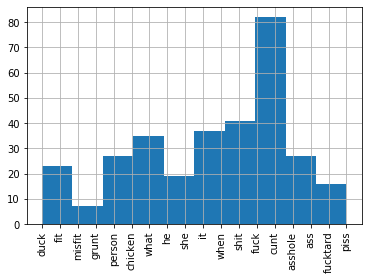

In [91]:
df.word.hist(xrot=90);

# Build precise datasets

In [92]:
def convert_mp3_to_wav(path):
    path_wav = path[:-3] + 'wav'
    if not os.path.exists(path_wav):
        os.system('sox {} -r 16000 {}'.format(path, path_wav))
    return path_wav

In [93]:
def resample_wav(path):
    path_wav = path[:-3] + '16k.wav'
    os.system('sox {} -r 16000 -b 16 {}'.format(path, path_wav))
    return path_wav

In [94]:
def build_dataset_from_df(df_train, df_test, ds_directory, overwrite=False):
    """Sort files into a mycroft-precise compatible training set using data
    from the data frame. Relevant columns in the data frame are 
    - swear (bool): is swear (=wake) word
    - file (str): path to .wav or .mp3 file (mp3 will be converted using SOX)
    """
    assert 'swear' in df_train.columns
    assert 'swear' in df_test.columns
    from shutil import copy, move
    
    if os.path.exists(ds_directory) and not overwrite:
        print('Directory already exists. Skipping.')
        return
    else:
        os.makedirs(ds_directory, exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'not-wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'test', 'wake-word'), exist_ok=True)
        os.makedirs(os.path.join(ds_directory, 'test', 'not-wake-word'), exist_ok=True)
    
    for is_train, df in zip((True, False), (df_train, df_test)):
        for idx, path, word, is_swear in df[['file', 'word', 'swear']].itertuples():
            #print(f'{path} swear={is_swear} train={is_train}')
            if path.endswith('.mp3'):
                path = convert_mp3_to_wav(path)
                op = move
            else:
                path = resample_wav(path)
                op = copy

            subdir = '.' if is_train else 'test'
            class_dir = 'wake-word' if is_swear else 'not-wake-word'
            name = f'{word}.{idx}.wav'
            target_dir = os.path.join(ds_directory, subdir, class_dir)

            op(path, os.path.join(target_dir, name))

In [95]:
def df_train_test_split(df):
    train_idx, test_idx = train_test_split(df.index, random_state=42, stratify=df.word)
    return df.loc[train_idx], df.loc[test_idx]

## "fuck" and all others in validation

In [96]:
simple_mask = df.word.isin(['fuck'])
df_simple = df[simple_mask]

df_simple_train, df_simple_test = df_train_test_split(df_simple)

# append all non-fuck samples to the test set
df_simple_test = df_simple_test.append(df[~simple_mask])

In [97]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(1.0, 0.45985401459854014)

In [98]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck_only'), 
    overwrite=True)

## "fuck" and non-swear words in train

In [99]:
simple_mask = df.word.isin(['fuck']) | ~df.swear
df_simple = df[simple_mask]
df_simple_train, df_simple_test = df_train_test_split(df_simple)

In [100]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(0.26490066225165565, 0.27450980392156865)

In [101]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck_and_non_swear'), 
    overwrite=True)

## "fuck" and non-swear words in train (balanced)

In [102]:
fuck_mask = df.word.isin(['fuck'])

In [103]:
# calculate smallest non-fuck word count and use it to 
# sample as many samples as there are fuck samples
n = int(np.ceil(
    fuck_mask.sum() / df[~df.swear].word.nunique()
))

In [104]:
nonfuck_idcs = df[(~df.swear)].groupby('word').apply(
    lambda x: x.sample(n) if len(x) > n else x
).index.levels[1]

In [106]:
# make sure nonfuck and fuck samples are approx. balanced
assert abs(len(nonfuck_idcs) - fuck_mask.sum()) < 5

In [107]:
df_simple = df[fuck_mask]
df_simple = df_simple.append(df.loc[nonfuck_idcs])

In [108]:
df_simple_train, df_simple_test = df_train_test_split(df_simple)

In [109]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(0.5063291139240507, 0.5185185185185185)

In [110]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck_and_non_swear_balanced'
    ), 
    overwrite=True)

## "fuck" + "shit" and non-swear words in train (balanced)

In [111]:
fuck_mask = df.word.isin(['fuck', 'shit'])

In [112]:
# calculate smallest non-fuck word count and use it to 
# sample as many samples as there are fuck samples
n = int(np.ceil(
    fuck_mask.sum() / df[~df.swear].word.nunique()
))

In [113]:
nonfuck_idcs = df[(~df.swear)].groupby('word').apply(
    lambda x: x.sample(n) if len(x) > n else x
).index.levels[1]

In [114]:
len(nonfuck_idcs), fuck_mask.sum()

(85, 95)

In [118]:
# make sure nonfuck and fuck samples are approx. balanced
assert abs(len(nonfuck_idcs) - fuck_mask.sum()) < 11

In [119]:
df_simple = df[fuck_mask]
df_simple = df_simple.append(df.loc[nonfuck_idcs])

In [120]:
df_simple_train, df_simple_test = df_train_test_split(df_simple)

In [121]:
df_simple_train.swear.mean(), df_simple_test.swear.mean()

(0.5185185185185185, 0.5555555555555556)

In [122]:
build_dataset_from_df(
    df_simple_train, 
    df_simple_test, 
    os.path.join(
        noswear2.dataset.DATA_ROOT, 
        'datasets', 
        'fuck+shit_and_non_swear_balanced'
    ), 
    overwrite=True)